In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 5.1 MB/s 
     |████████████████████████████████| 7.6 MB 45.6 MB/s 
     |████████████████████████████████| 163 kB 56.1 MB/s 


In [2]:
import transformers
import pandas as pd
import numpy as np
import urllib.request
import os
from tqdm import tqdm
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
from transformers import AutoModel, AutoTokenizer

In [4]:
kr_data = pd.read_csv('./drive/MyDrive/newKR.csv')

jp_data = pd.read_csv('./drive/MyDrive/newJPppp.csv')

kr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   39900 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [5]:
jp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39397 entries, 0 to 39396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   39397 non-null  object
 1   label   39397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 615.7+ KB


v2열의 유니크한 값 : 38523
총 샘플의 수 : 38523


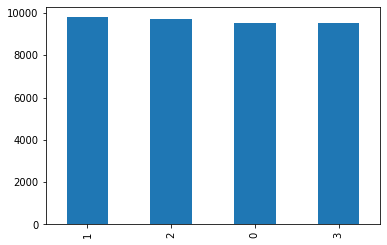

In [6]:
print('v2열의 유니크한 값 :',jp_data['tweet'].nunique())

jp_data.drop_duplicates(subset=['tweet'], inplace=True)

print('총 샘플의 수 :',len(jp_data))

jp_data['label'].value_counts().plot(kind='bar')

In [7]:
x_jpdata = jp_data['tweet']
y_jpdata = jp_data['label']

print('메일 본문의 개수: {}'.format(len(x_jpdata)))
print('레이블의 개수: {}'.format(len(y_jpdata)))

X_jptrain, X_jptest, y_jptrain, y_jptest = train_test_split(x_jpdata, y_jpdata, test_size=0.2, random_state=0, stratify=y_jpdata)

메일 본문의 개수: 38523
레이블의 개수: 38523


In [8]:
!pip install fugashi[unidic-lite]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 583 kB 5.5 MB/s 
     |████████████████████████████████| 47.4 MB 52.0 MB/s 
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658836 sha256=a18f60206b33fb87c9153f5eb0eaec3fede672562fafc5ecba946ddda6201244
  Stored in directory: /root/.cache/pip/wheels/de/69/b1/112140b599f2b13f609d485a99e357ba68df194d2079c5b1a2
Successfully built unidic-lite


In [9]:
!pip install ipadic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.4 MB 326 kB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=11481550fb61b857fddbc21b5070b7330dc89a63d1620a37d3b2ff143de6e6b2
  Stored in directory: /root/.cache/pip/wheels/33/8b/99/cf0d27191876637cd3639a560f93aa982d7855ce826c94348b
Successfully built ipadic


In [10]:
from fugashi import Tagger
import ipadic

In [11]:
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese")

Downloading:   0%|          | 0.00/104 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

In [12]:
max_seq_len = 256

In [13]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):
    
    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []
    
    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        input_id = tokenizer.encode(example, max_length=max_seq_len, pad_to_max_length=True)
        padding_count = input_id.count(tokenizer.pad_token_id)
        attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count
        token_type_id = [0] * max_seq_len

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    data_labels = np.asarray(data_labels, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), data_labels

In [14]:
train_jpX, train_jpy = convert_examples_to_features(X_jptrain, y_jptrain, 
                                                max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|          | 0/30818 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 30818/30818 [00:40<00:00, 766.35it/s] 


In [15]:
test_jpX, test_jpy = convert_examples_to_features(X_jptest, y_jptest, 
                                              max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 7705/7705 [00:03<00:00, 2507.41it/s]


In [16]:
input_id = train_jpX[0][0]
attention_mask = train_jpX[1][0]
token_type_id = train_jpX[2][0]
label = train_jpy[0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print(input_id)
print('정수 인코딩 복원 :',tokenizer.decode(input_id))
print('레이블 :',label)

단어에 대한 정수 인코딩 : [    2    97    52  5648   224 28902   337  8592  1592  1778   265  5648
  6819  2731  2543 23269    12  2501     3     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     

In [17]:
model = AutoModel.from_pretrained("cl-tohoku/bert-base-japanese")

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
class TFBertForSequenceClassification(tf.keras.Model):
    def __init__(self, model_name):
        super(TFBertForSequenceClassification, self).__init__()
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True, num_hidden_layers	=12, hidden_dropout_prob=0.25)
        self.classifier = tf.keras.layers.Dense(4,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                activation='sigmoid',
                                                name='classifier')

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_token = outputs[1]
        prediction = self.classifier(cls_token)

        return prediction

In [19]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [20]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import h5py

In [22]:
local_device_option = tf.saved_model.SaveOptions(experimental_io_device="/job:localhost")

In [23]:
with strategy.scope():
  model = TFBertForSequenceClassification("cl-tohoku/bert-base-japanese")
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, decay=3e-5)
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  mc = ModelCheckpoint('best_modeljp', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_weight_only=True, save_format="tf", options=local_device_option)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
  model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [25]:
history = model.fit(train_jpX, train_jpy, epochs=30, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/30
386/386 [==============================] - ETA: 0s - loss: 0.5377 - accuracy: 0.7990
Epoch 1: val_accuracy improved from -inf to 0.84848, saving model to best_modeljp


386/386 [==============================] - 296s 523ms/step - loss: 0.5377 - accuracy: 0.7990 - val_loss: 0.3972 - val_accuracy: 0.8485
Epoch 2/30
386/386 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.8842
Epoch 2: val_accuracy improved from 0.84848 to 0.89341, saving model to best_modeljp


386/386 [==============================] - 138s 358ms/step - loss: 0.3215 - accuracy: 0.8842 - val_loss: 0.3116 - val_accuracy: 0.8934
Epoch 3/30
386/386 [==============================] - ETA: 0s - loss: 0.1922 - accuracy: 0.9345
Epoch 3: val_accuracy improved from 0.89341 to 0.91742, saving model to best_modeljp


386/386 [==============================] - 135s 349ms/step - loss: 0.1922 - accuracy: 0.9345 - val_loss: 0.2397 - val_accuracy: 0.9174
Epoch 4/30
386/386 [==============================] - ETA: 0s - loss: 0.1087 - accuracy: 0.9641
Epoch 4: val_accuracy improved from 0.91742 to 0.92829, saving model to best_modeljp


386/386 [==============================] - 134s 347ms/step - loss: 0.1087 - accuracy: 0.9641 - val_loss: 0.2343 - val_accuracy: 0.9283
Epoch 5/30
386/386 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9773
Epoch 5: val_accuracy improved from 0.92829 to 0.94922, saving model to best_modeljp


386/386 [==============================] - 135s 349ms/step - loss: 0.0696 - accuracy: 0.9773 - val_loss: 0.1723 - val_accuracy: 0.9492
Epoch 6/30
386/386 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9840
Epoch 6: val_accuracy did not improve from 0.94922
386/386 [==============================] - 60s 157ms/step - loss: 0.0488 - accuracy: 0.9840 - val_loss: 0.2250 - val_accuracy: 0.9445
Epoch 7/30
386/386 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9861
Epoch 7: val_accuracy did not improve from 0.94922
386/386 [==============================] - 61s 157ms/step - loss: 0.0412 - accuracy: 0.9861 - val_loss: 0.2225 - val_accuracy: 0.9434
Epoch 8/30
386/386 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9908
Epoch 8: val_accuracy did not improve from 0.94922
386/386 [==============================] - 61s 158ms/step - loss: 0.0282 - accuracy: 0.9908 - val_loss: 0.2697 - val_accuracy: 0.9470
Epoch 9/30
386/386 [==

386/386 [==============================] - 138s 358ms/step - loss: 0.0249 - accuracy: 0.9920 - val_loss: 0.2319 - val_accuracy: 0.9518
Epoch 10/30
386/386 [==============================] - ETA: 0s - loss: 0.0233 - accuracy: 0.9922
Epoch 10: val_accuracy did not improve from 0.95182
386/386 [==============================] - 61s 157ms/step - loss: 0.0233 - accuracy: 0.9922 - val_loss: 0.2034 - val_accuracy: 0.9494
Epoch 11/30
386/386 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9945
Epoch 11: val_accuracy improved from 0.95182 to 0.95247, saving model to best_modeljp


386/386 [==============================] - 135s 350ms/step - loss: 0.0185 - accuracy: 0.9945 - val_loss: 0.2331 - val_accuracy: 0.9525
Epoch 12/30
386/386 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9948
Epoch 12: val_accuracy did not improve from 0.95247
386/386 [==============================] - 61s 157ms/step - loss: 0.0172 - accuracy: 0.9948 - val_loss: 0.2868 - val_accuracy: 0.9495
Epoch 13/30
386/386 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9932
Epoch 13: val_accuracy did not improve from 0.95247
386/386 [==============================] - 61s 157ms/step - loss: 0.0215 - accuracy: 0.9932 - val_loss: 0.2673 - val_accuracy: 0.9512
Epoch 14/30
386/386 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9942
Epoch 14: val_accuracy improved from 0.95247 to 0.95782, saving model to best_modeljp


386/386 [==============================] - 143s 372ms/step - loss: 0.0192 - accuracy: 0.9942 - val_loss: 0.2037 - val_accuracy: 0.9578
Epoch 15/30
386/386 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9963
Epoch 15: val_accuracy did not improve from 0.95782
386/386 [==============================] - 61s 157ms/step - loss: 0.0120 - accuracy: 0.9963 - val_loss: 0.2412 - val_accuracy: 0.9555
Epoch 15: early stopping


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model (TFBertModel)  multiple                 110617344 
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 110,620,420
Trainable params: 110,620,420
Non-trainable params: 0
_________________________________________________________________


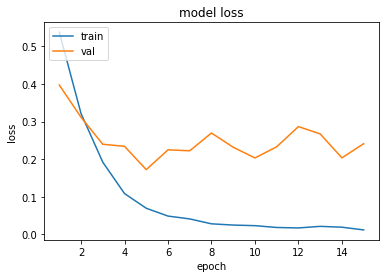

In [26]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

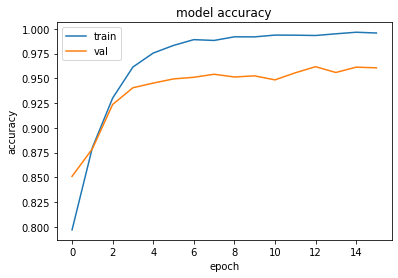

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [27]:
results = model.evaluate(test_jpX, test_jpy, batch_size=1024)
print("test loss, test acc: ", results)

8/8 [==============================] - 23s 2s/step - loss: 0.2590 - accuracy: 0.9500
test loss, test acc:  [0.2589869201183319, 0.9500324726104736]
